In [31]:
!pip install pandas_ta
!pip install neat-python
!pip install visualize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11479 sha256=ea9e152b6fb3743686ab5f2e5cc95d1a6f5096511cd3298890148e8da72304cd
  Stored in directory: /root/.cache/pip/wheels/00/3a/5c/36e2da8b63978326a610c9b99af5da59d657ef97b854780d5a
Successfully built visualize


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import visualize
import random
import neat
import os
import os.path

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


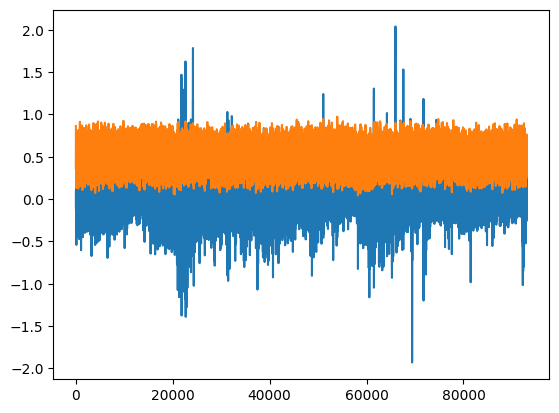

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [12]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [89]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     '/content/drive/MyDrive/config-feedforward')

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [94]:
winner = p.run(eval_genomes,50)


 ****** Running generation 50 ****** 

Population's average fitness: 104.26630 stdev: 112.75600
Best fitness: 283.02629 - size: (4, 4) - species 2 - id 6726
Average adjusted fitness: 0.640
Mean genetic distance 1.933, standard deviation 0.397
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 2.403 sec (2.272 average)

 ****** Running generation 51 ****** 

Population's average fitness: 118.47855 stdev: 135.49520
Best fitness: 354.23897 - size: (4, 4) - species 2 - id 6726
Average adjusted fitness: 0.526
Mean genetic distance 1.917, standard deviation 0.422
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 2.175 sec (2.279 average)

 ****** Running generation 52 ****** 

Population's average fitness: 3.75844 stdev: 66.66443
Best fitness: 137.44413 - size: (4, 4) - species 2 - id 6726
Average adjusted fitness: 0.630
Mean genetic distance 1.943, standard deviation 0.451
Population of 150 members in 2 species
Total extinctions: 0
Gener

In [95]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [96]:
run_env_loop(net,80000,True)

[1.         0.21895992 0.         0.21895992]
0
[-1.         -0.06014551  0.         -0.06014551]
0.21895992116917998
[ 1.         -0.11992821  0.         -0.11992821]
-0.0601455097729687
[-1.          0.33178845  0.          0.33178845]
-0.11992821352884313
[ 1.         -0.29274556  0.         -0.29274556]
0.3317884517234796
[1.         0.37205053 0.1        0.37205053]
0
[1.         0.59789813 0.2        0.59789813]
0
[-1.          0.09258168  0.          0.09258168]
0.5978981307915293
[-1.          1.82626916  0.          1.82626916]
0.09258168361815453
[-1.          0.29947671  0.          0.29947671]
1.8262691584931812
[-1.          0.91250084  0.          0.91250084]
0.29947670938120163
[-1.          0.68699198  0.          0.68699198]
0.9125008408824559
[-1.          0.82794031  0.          0.82794031]
0.686991976774094
[-1.         -0.24703461  0.         -0.24703461]
0.8279403145300622
[-1.          0.04700826  0.          0.04700826]
-0.24703461381697833
[-1.          1.01612

154.22891505110795

In [97]:
node = winner.nodes
conec = winner.connections
print(winner)

Key: 14578
Fitness: 282.1747148342081
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.5834374340842275, response=1.0, activation=abs, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.7151754666407728, response=1.0, activation=clamped, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.6273077059743833, response=1.0, activation=relu, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=1.3732045391424625, response=1.0, activation=clamped, aggregation=sum)
	24 DefaultNodeGene(key=24, bias=-1.1976762968984356, response=1.0, activation=clamped, aggregation=sum)
	425 DefaultNodeGene(key=425, bias=-1.6469156098075057, response=1.0, activation=clamped, aggregation=sum)
	1220 DefaultNodeGene(key=1220, bias=-0.7980251740825306, response=1.0, activation=clamped, aggregation=sum)
	1701 DefaultNodeGene(key=1701, bias=4.545624237393966, response=1.0, activation=relu, aggregation=sum)
	1838 DefaultNodeGene(key=1838, bias=2.9588358447191987, response=1.0, activation=clamped, aggregation=sum)
	1937 DefaultNodeGe